<a href="https://colab.research.google.com/github/daniilwithangelic/laba-in-car-obychen/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [3]:
# Загрузка набора данных
df = pd.read_csv('/content/income.csv')

In [4]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [5]:
df['is_work'] = np.where(df['hours-per-week'] >= 35, 1, 0)
df.is_work = df.is_work.astype('category')
df['sex'] = df['sex'].astype('category')

In [6]:
Y = df['is_work'] # выбираем целевую переменную (категориальную)
X = df.drop('is_work', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('hours-per-week', axis=1)

In [7]:
df.drop('hours-per-week', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       30725 non-null  object  
 2   education       32561 non-null  object  
 3   education-num   32561 non-null  int64   
 4   marital-status  32561 non-null  object  
 5   occupation      30718 non-null  object  
 6   relationship    32561 non-null  object  
 7   race            32561 non-null  object  
 8   sex             32561 non-null  category
 9   capital-gain    32561 non-null  int64   
 10  capital-loss    32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
 13  is_work         32561 non-null  category
dtypes: category(2), int64(5), object(7)
memory usage: 3.0+ MB


In [8]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K,is_work
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,1
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,1
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,0


## 2: масштабирование признаков

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       30725 non-null  object  
 2   education       32561 non-null  object  
 3   education-num   32561 non-null  int64   
 4   marital-status  32561 non-null  object  
 5   occupation      30718 non-null  object  
 6   relationship    32561 non-null  object  
 7   race            32561 non-null  object  
 8   sex             32561 non-null  category
 9   capital-gain    32561 non-null  int64   
 10  capital-loss    32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
dtypes: category(1), int64(5), object(7)
memory usage: 3.0+ MB


In [10]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True,dtype=int) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [11]:
X_processed

,age,workclass,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,native-country,income >50K,sex_Male
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,2174,0,United-States,0,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,United-States,0,1
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,United-States,0,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,United-States,0,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,Cuba,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,0,0,United-States,0,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,0,0,United-States,1,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,0,0,United-States,0,0
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,0,0,United-States,0,1


In [12]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [13]:
X_processed

,age,workclass,education,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,native-country,income >50K,sex_Male
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,0.021740,0.0,United-States,0.0,1.0
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,0.000000,0.0,United-States,0.0,1.0
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,0.000000,0.0,United-States,0.0,1.0
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,0.000000,0.0,United-States,0.0,1.0
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,0.000000,0.0,Cuba,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,Private,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,White,0.000000,0.0,United-States,0.0,0.0
32557,0.315068,Private,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,0.000000,0.0,United-States,1.0,1.0
32558,0.561644,Private,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,White,0.000000,0.0,United-States,0.0,0.0
32559,0.068493,Private,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,White,0.000000,0.0,United-States,0.0,1.0


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [14]:
from sklearn.model_selection import cross_val_score

# def train_and_evaluate(X, Y):
#     # Разделение данных на обучающую и тестовую выборки
#     X_train, X_test, Y_train, Y_test = train_test_split(
#         X, Y, test_size=0.2, random_state=42, stratify=Y)

#     # Инициализация модели
#     model = LogisticRegression(max_iter=1000)

#     # Обучение модели
#     model.fit(X_train, Y_train)

#     # Предсказания на обучающей выборке
#     Y_train_pred = model.predict(X_train)
#     train_accuracy = accuracy_score(Y_train, Y_train_pred)

#     # Предсказания на тестовой выборке
#     Y_test_pred = model.predict(X_test)
#     test_accuracy = accuracy_score(Y_test, Y_test_pred)

#     # Вывод результатов
#     print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
#     print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

#     # Классификационный отчет
#     print("\nКлассификационный отчет на тестовой выборке:")
#     print(classification_report(Y_test, Y_test_pred))

#     return model

def preprocess_data(X):
    # Применяем One-Hot Encoding к категориальным переменным
    category_columns = X.select_dtypes(include=['object']).columns
    if len(category_columns) > 0:
        print("Кодируем категориальные переменные:", category_columns.tolist())
        X = pd.get_dummies(X, columns=category_columns, drop_first=True, dtype=int)

    # Преобразуем 'sex' в числовые значения, если она еще не закодирована
    if 'sex' in X.columns:
        X['sex'] = X['sex'].map({'Male': 1, 'Female': 0})  # Преобразование в 0 и 1

    # Проверяем типы данных после One-Hot Encoding
    print("Типы данных после One-Hot Encoding:")
    print(X.dtypes)

    return X

def train_and_evaluate(X, Y):
    # Проверяем, есть ли еще категориальные переменные
    if any(X.dtypes == 'object'):
        print("В X остались категориальные переменные.")
        return

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model

# Препроцессинг данных
X_processed = preprocess_data(X.copy())

# Проверяем, есть ли еще категориальные переменные
if any(X_processed.dtypes == 'object'):
    print("В X_processed остались категориальные переменные.")
else:
    print("Все переменные в X_processed числовые.")

Кодируем категориальные переменные: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Типы данных после One-Hot Encoding:
age                                  int64
education-num                        int64
sex                               category
capital-gain                         int64
capital-loss                         int64
                                    ...   
native-country_Thailand              int64
native-country_Trinadad&Tobago       int64
native-country_United-States         int64
native-country_Vietnam               int64
native-country_Yugoslavia            int64
Length: 96, dtype: object
Все переменные в X_processed числовые.


In [15]:
# Обучаем и оцениваем модель
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.8414
Точность на тестовой выборке: 0.8439

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.62      0.24      0.34      1117
           1       0.86      0.97      0.91      5396

    accuracy                           0.84      6513
   macro avg       0.74      0.60      0.63      6513
weighted avg       0.82      0.84      0.81      6513



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [16]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [17]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [18]:
X_processed.describe()

,age,education-num,capital-gain,capital-loss,income >50K,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,0.240810,0.064279,0.000215,0.697030,0.034274,0.078038,...,0.001136,0.003501,0.000369,0.002457,0.001566,0.000553,0.000584,0.895857,0.002058,0.000491
std,13.640433,2.572720,7385.292085,402.960219,0.427581,0.245254,0.014661,0.459549,0.181935,0.268236,...,0.033691,0.059068,0.019194,0.049507,0.039546,0.023506,0.024149,0.305451,0.045316,0.022162
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
X_iqr.describe()

,age,education-num,capital-gain,capital-loss,income >50K,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,505.000000,505.000000,505.0,505.0,505.0,505.0,505.0,505.000000,505.0,505.0,...,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0
mean,42.940594,8.845545,0.0,0.0,0.0,0.0,0.0,0.590099,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
std,16.025044,0.663613,0.0,0.0,0.0,0.0,0.0,0.492303,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,18.000000,6.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25%,29.000000,9.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50%,42.000000,9.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,56.000000,9.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,82.000000,9.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.8243
Точность на тестовой выборке: 0.8020

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.50      0.05      0.09        20
           1       0.81      0.99      0.89        81

    accuracy                           0.80       101
   macro avg       0.65      0.52      0.49       101
weighted avg       0.75      0.80      0.73       101



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**


***1. Сравнение описательных статистик***

Описание данных до удаления выбросов (X_processed.describe()):
Количество наблюдений: 32,561
Возраст (age):
Среднее: 38.58
Стандартное отклонение: 13.64
Минимум: 17
Максимум: 90
Образование (education-num):
Среднее: 10.08
Стандартное отклонение: 2.57
Капитал (capital-gain):
Среднее: 1077.65 (с большим разбросом, максимум 99,999)
Капитал (capital-loss):
Среднее: 87.30 (также с разбросом, максимум 4,356)
Описание данных после удаления выбросов (X_iqr.describe()):
Количество наблюдений: 505
Возраст (age):
Среднее: 42.94
Стандартное отклонение: 16.03
Минимум: 18
Максимум: 82
Образование (education-num):
Среднее: 8.85
Стандартное отклонение: 0.66
Капитал (capital-gain):
Среднее: 0.00 (все выбросы удалены)
Капитал (capital-loss):
Среднее: 0.00 (все выбросы удалены)

***2. Анализ изменений***

Количество наблюдений: После удаления выбросов количество наблюдений уменьшилось с 32,561 до 505, что указывает на то, что в исходных данных было много экстремальных значений.
Возраст: Средний возраст увеличился с 38.58 до 42.94, что может указывать на то, что более молодые наблюдения были выбросами.
Образование: Среднее значение образования уменьшилось с 10.08 до 8.85, что также может свидетельствовать о том, что в данных были наблюдения с высоким уровнем образования, которые были выбросами.
Капитал: Все наблюдения по капиталу (как приросту, так и убытку) были удалены как выбросы, что указывает на их значительное влияние на данные.

3. **Производительность модели**

После удаления выбросов модель логистической регрессии показала следующие результаты:

Точность на обучающей выборке: 0.8243
Точность на тестовой выборке: 0.8020
Классификационный отчет:

Precision (точность):
Для класса 0: 0.50
Для класса 1: 0.81
Recall (полнота):
Для класса 0: 0.05
Для класса 1: 0.99
F1-score:
Для класса 0: 0.09
Для класса 1: 0.89

4. ***Выводы***

Проблема с дисбалансом классов: Модель показывает хорошую точность для класса 1 (положительный класс), но очень низкую для класса 0 (отрицательный класс). Это указывает на наличие проблемы с дисбалансом классов, что может быть связано с удалением значительного количества наблюдений.
Влияние выбросов: Удаление выбросов значительно изменило распределение данных, что, в свою очередь, повлияло на производительность модели. Хотя точность увеличилась, модель может быть менее надежной для предсказания класса 0.
Рекомендации: Рассмотрите возможность использования методов балансировки классов (например, oversampling или undersampling) или применения более сложных моделей, которые могут лучше справляться с дисбалансом классов. Также можно рассмотреть возможность использования других метрик для оценки модели, таких как ROC-AUC, чтобы лучше понять её производительность.
Заключение
Удаление выбросов с использованием метода IQR привело к значительным изменениям в данных и производительности модели. Важно продолжать анализировать и тестировать различные подходы к обработке данных, чтобы достичь наилучших результатов в задачах машинного обучения.

### Метод 2: удаление на основе среднего

In [26]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [27]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [28]:
X_processed.describe()

,age,education-num,capital-gain,capital-loss,income >50K,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,0.240810,0.064279,0.000215,0.697030,0.034274,0.078038,...,0.001136,0.003501,0.000369,0.002457,0.001566,0.000553,0.000584,0.895857,0.002058,0.000491
std,13.640433,2.572720,7385.292085,402.960219,0.427581,0.245254,0.014661,0.459549,0.181935,0.268236,...,0.033691,0.059068,0.019194,0.049507,0.039546,0.023506,0.024149,0.305451,0.045316,0.022162
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
X_mean.describe()

,age,education-num,capital-gain,capital-loss,income >50K,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,968.000000,968.000000,968.000000,968.0,968.000000,968.0,968.0,968.000000,968.0,968.0,...,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0
mean,39.666322,9.339876,346.560950,0.0,0.147727,0.0,0.0,0.639463,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
std,13.715503,0.714151,1602.312793,0.0,0.355013,0.0,0.0,0.480405,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,18.000000,6.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25%,27.000000,9.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50%,38.000000,9.000000,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,51.000000,10.000000,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,65.000000,10.000000,15024.000000,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.8475
Точность на тестовой выборке: 0.8454

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.85      1.00      0.92       164

    accuracy                           0.85       194
   macro avg       0.42      0.50      0.46       194
weighted avg       0.71      0.85      0.77       194



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**


***1. Сравнение описательных статистик***

Данные до удаления выбросов (X_processed.describe()):
Возраст (age):
Среднее: 38.58
Стандартное отклонение: 13.64
Минимум: 17
Максимум: 90
Образование (education-num):
Среднее: 10.08
Стандартное отклонение: 2.57
Капитал (capital-gain):
Среднее: 1077.65
Стандартное отклонение: 7385.29
Максимум: 99,999
Капитал (capital-loss):
Среднее: 87.30
Стандартное отклонение: 402.96
Максимум: 4,356
Данные после удаления выбросов на основе среднего (X_mean.describe()):
Возраст (age):
Среднее: 39.67
Стандартное отклонение: 13.72
Минимум: 18
Максимум: 65
Образование (education-num):
Среднее: 9.34
Стандартное отклонение: 0.71
Капитал (capital-gain):
Среднее: 346.56
Стандартное отклонение: 1602.31
Максимум: 15,024
Капитал (capital-loss):
Среднее: 0.00
Стандартное отклонение: 0.00

2. ***Анализ изменений***

Количество наблюдений: После удаления выбросов количество наблюдений уменьшилось до 968.
Возраст: Средний возраст немного увеличился с 38.58 до 39.67, что указывает на то, что более молодые наблюдения были выбросами. Максимальный возраст сократился с 90 до 65.
Образование: Среднее значение образования уменьшилось с 10.08 до 9.34, что может свидетельствовать о том, что в данных были наблюдения с высоким уровнем образования, которые были выбросами.
Капитал: Среднее значение по капиталу значительно сократилось с 1077.65 до 346.56, что говорит о том, что выбросы с высоким капиталом были удалены. Капитал-убыток стал равным 0 для всех наблюдений, что указывает на отсутствие выбросов в этой категории.

3. ***Производительность модели***

После удаления выбросов модель логистической регрессии показала следующие результаты:

Точность на обучающей выборке: 0.8475
Точность на тестовой выборке: 0.8454
Классификационный отчет:

Precision (точность):
Для класса 0: 0.00 (модель не предсказала ни одного наблюдения класса 0)
Для класса 1: 0.85
Recall (полнота):
Для класса 0: 0.00
Для класса 1: 1.00
F1-score:
Для класса 0: 0.00
Для класса 1: 0.92

4. ***Выводы***

Проблема с дисбалансом классов: Модель показывает отличные результаты для класса 1, но не может предсказать класс 0, что указывает на серьезную проблему с дисбалансом классов. Это может быть связано с тем, что после удаления выбросов количество наблюдений для класса 0 стало очень малым.
Влияние выбросов: Удаление выбросов на основе среднего значения привело к значительным изменениям в распределении данных, особенно для переменных, связанных с капиталом. Это также повлияло на производительность модели, которая стала более точной, но менее сбалансированной.
Рекомендации: Для улучшения модели рекомендуется использовать методы балансировки классов (например, oversampling для класса 0) и более сложные алгоритмы, такие как случайные леса или градиентный бустинг. Также стоит рассмотреть возможность использования других метрик для оценки производительности, таких как ROC-AUC, чтобы лучше понять поведение модели.

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [31]:
from sklearn.feature_selection import SelectKBest, f_regression


In [32]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed, Y)


In [33]:
selector.scores_

array([1.89117323e+02, 3.69459771e+02, 1.19659997e+03, 5.39203087e+01,
       5.17979141e+01, 1.12123381e+03, 5.34679815e+01, 3.25806401e+00,
       4.03912900e+01, 7.82840990e+01, 5.63749777e+00, 1.54866403e+00,
       1.57783760e+01, 3.88443513e+02, 6.29540073e+01, 5.27824031e+00,
       9.39193874e-02, 8.24760171e+00, 3.07604052e+00, 1.67166753e-01,
       4.50435049e+01, 1.67203707e+02, 1.53509138e+01, 6.02418243e+01,
       7.24194311e+01, 5.40983463e+00, 1.96802950e+01, 2.05184763e+02,
       3.41739695e-01, 1.19272609e+03, 3.01081688e-02, 1.34150388e+03,
       4.45399750e-04, 3.60182698e+02, 2.30800005e-01, 4.11520145e+02,
       3.75443462e+02, 5.90642430e+00, 1.74937748e+01, 1.44949372e+02,
       1.11680106e+03, 1.07209825e+02, 7.03615590e+01, 2.58141301e+01,
       5.79210943e+01, 3.48201855e+00, 6.89328473e+01, 7.83926448e+00,
       4.48341566e+01, 2.36610561e+03, 2.96461968e-03, 6.93624292e+01,
       1.85588086e-01, 2.14702142e+00, 5.38322036e-01, 1.21109968e+00,
      

In [34]:
X_processed.columns

Index(['age', 'education-num', 'sex', 'capital-gain', 'capital-loss',
       'income >50K', 'workclass_Local-gov', 'workclass_Never-worked',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
     

In [35]:
X_processed

,age,education-num,sex,capital-gain,capital-loss,income >50K,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,1,2174,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,9,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,9,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,9,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [36]:
selector.get_support(indices=True)

array([ 2,  5, 29, 31, 49])

In [37]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['sex', 'income >50K', 'marital-status_Married-civ-spouse',
       'marital-status_Never-married', 'relationship_Own-child'],
      dtype='object')


In [38]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.8302
Точность на тестовой выборке: 0.8302

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.51      0.17      0.26      1117
           1       0.85      0.97      0.90      5396

    accuracy                           0.83      6513
   macro avg       0.68      0.57      0.58      6513
weighted avg       0.79      0.83      0.79      6513



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [39]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Отобранные признаки: Index(['income >50K', 'marital-status_Widowed', 'occupation_Craft-repair',
       'occupation_Machine-op-inspct', 'relationship_Own-child'],
      dtype='object')


In [40]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.8282
Точность на тестовой выборке: 0.8280

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1117
           1       0.83      1.00      0.91      5396

    accuracy                           0.83      6513
   macro avg       0.41      0.50      0.45      6513
weighted avg       0.69      0.83      0.75      6513



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Коэффициенты модели без регуляризации: [[-1.87478044e-02  6.10492661e-02  6.56673496e-01  1.01577281e-06
   8.90425886e-05  1.10300160e+00  8.11147929e-01 -1.58625796e-03
   6.42925786e-01  3.85222870e-01 -1.95669867e-01  3.13724638e-01
  -3.38004310e-02 -4.82316125e-01 -1.34931637e-01  1.01019661e-01
   2.60287439e-01  2.65641557e-01  2.30611567e-01 -1.32802541e-01
   3.28954899e-01  6.57214825e-02 -1.04399896e-01  3.89022034e-01
  -4.05847992e-02  3.14495489e-02 -1.38237385e-01 -1.07660063e-01
  -3.94254490e-03  3.05833943e-01 -4.57832770e-03 -5.45881033e-01
   4.41192226e-02 -8.03989692e-01  5.07000487e-03  9.79163561e-01
   8.27706208e-01  2.79740530e-01 -1.89372734e-01  8.56530209e-01
  -8.57312925e-01 -2.32166280e-01 -2.01118499e-02  1.77461346e-01
  -3.38060127e-01  1.57396702e-02  3.40903791e-01  4.54897614e-01
  -1.10548431e-01 -7.49907986e-01  6.46181014e-01 -7.39483575e-01
   3.08915764e-02  3.91976245e-01  1.44077118e-02  7.31435298e-02
  -5.71012912e-02 -3.76035155e-02 -3.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели после отбора признаков: [[-1.98095450e-02  4.48395874e-02  4.42704764e-01  8.09500486e-05
   1.08209346e+00  9.79714377e-01  6.76507687e-01  8.77249285e-01
  -2.50072587e-02  5.79253547e-01 -7.05340924e-01 -4.64391140e-01
  -1.84526677e-01  8.27050807e-02  4.16775395e-01  2.65360262e-01
   2.96525852e-01  6.73380082e-02  6.08796522e-01  3.20839137e-01
   4.40220668e-01  1.92296435e-01 -5.39801014e-02  0.00000000e+00
  -3.79041082e-02 -4.37713340e-01 -8.25174043e-01 -3.39015545e-01
  -1.07523193e+00  1.36862458e-01  9.74075746e-01  7.74784838e-01
   4.98861504e-01 -8.82186406e-02  9.61099641e-01 -7.26908819e-01
  -1.05041189e+00  4.66210923e-02  2.34925747e-01 -2.34367641e-01
   4.92246077e-02  4.85025694e-01  2.76282098e-01 -2.57800236e-01
  -9.08396168e-01  2.44322764e-01 -9.59652037e-01 -4.57211514e-04
   2.72665701e-01 -1.41185618e-01 -9.05870483e-02 -4.92866070e-01
  -5.17529753e-01  0.00000000e+00  1.07068883e+00 -8.61347472e-01
   4.59956519e-02 -2.58557829e-0

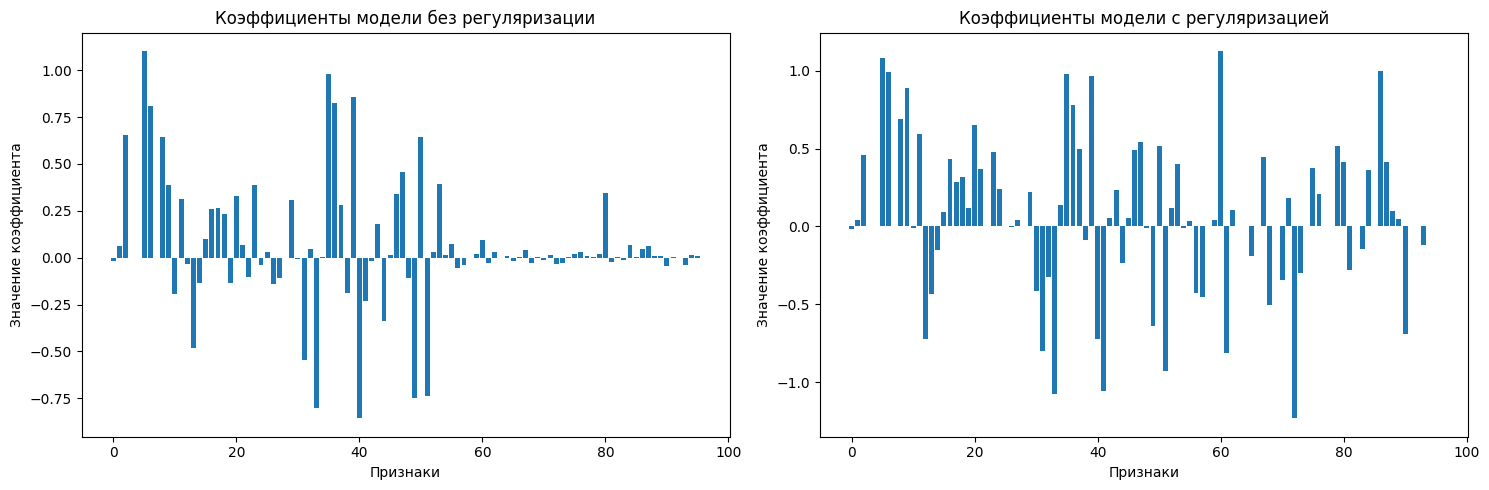

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [42]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.8414
Точность на тестовой выборке: 0.8435

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.61      0.24      0.34      1117
           1       0.86      0.97      0.91      5396

    accuracy                           0.84      6513
   macro avg       0.74      0.60      0.63      6513
weighted avg       0.82      0.84      0.81      6513



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [43]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [44]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [56]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [57]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=200)  # Увеличьте с 100 до 200


# # K-Fold Cross-Validation
# def k_fold_cross_validation(X, y, n_splits=5):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     accuracies = []

#     # Реализация K-Fold вручную
#     for train_index, test_index in kf.split(X):
#         model = LogisticRegression(max_iter=1000)
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         # Обучение модели на тренировочной выборке
#         model.fit(X_train, y_train)

#         # Предсказания на тестовой выборке
#         y_pred = model.predict(X_test)

#         # Оценка точности
#         accuracy = accuracy_score(y_test, y_pred)
#         accuracies.append(accuracy)

#     # Выводим среднюю точность и точности по каждому фолду
#     print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
#     print(f"Точности по каждому фолду: {accuracies}")

# # Пример использования:
# k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())

# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        # Создаем пайплайн с масштабированием и логистической регрессией
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))  # Увеличиваем max_iter
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)
        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)
        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")
# Пример использования:
k_fold_cross_validation(X=X_processed.to_numpy(), y=Y.to_numpy())



K-Fold Cross-Validation - Средняя точность: 0.8402690225295014
Точности по каждому фолду: [0.8406264394288346, 0.8447481572481572, 0.8433660933660934, 0.8373771498771498, 0.8352272727272727]


*Нет значительного выйгрыша в точности, так как повышинная точность в одних фолдах компенсируется пониженной в других*

### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [58]:
# # ShuffleSplit Cross-Validation
# def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
#     ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
#     accuracies = []

#     # Реализация ShuffleSplit вручную
#     for train_index, test_index in ss.split(X):
#         model = LogisticRegression(max_iter=1000)
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         # Обучение модели на тренировочной выборке
#         model.fit(X_train, y_train)

#         # Предсказания на тестовой выборке
#         y_pred = model.predict(X_test)

#         # Оценка точности
#         accuracy = accuracy_score(y_test, y_pred)
#         accuracies.append(accuracy)

#     # Выводим среднюю точность и точности по каждому разделению
#     print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
#     print(f"Точности по каждому разделению: {accuracies}")

# # Пример использования:
# shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())

# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    accuracies = []
    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        # Создаем пайплайн с масштабированием и логистической регрессией
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))  # Увеличиваем max_iter
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)
        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)
        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")
# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())

ShuffleSplit Cross-Validation - Средняя точность: 0.8417811900191937
Точности по каждому разделению: [0.8429174664107486, 0.8425335892514395, 0.8410748560460652, 0.8449136276391555, 0.8374664107485604]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [48]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.8395516658989712
Точность на тестовых данных: 0.8414587332053742


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***Как мы можем видеть, результат примерно +- везде одинаковый, нет больших изменений. Нет перебора, так как данные делятся на три части***

### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

Train-Test-Validation Split больше подходит для моего датасета, так как используется большой объем данных
